## Inspect Trained Model


In [316]:
import math
import os

import matplotlib.pyplot as plt
import torch
import yaml
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf
from torch.utils.data import Dataset

import data
from networks import *
from utils import mse2psnr

### Select model to inspect


In [317]:
exp_name = "non_continual"
# exp_name = "continual_base"
# exp_name = "l1_1e-3"

date = "2022.12.27"
ids = [dir for dir in os.listdir(f"exp/{exp_name}/{date}") if not dir.startswith(".")]

# Take the first ID under this date
id = ids[0]
# Or specify ID
# id = "234224"

path = f"exp/{exp_name}/{date}/{id}"

config_path = f"{path}/.hydra/config.yaml"
ckpt_path = f"{path}/ckpt/final.pt"

In [318]:
# Load config
with open(config_path, "r") as stream:
    config = yaml.safe_load(stream)
    cfg = DictConfig(config)

# Load model
model = instantiate(cfg.network)
ckpt = torch.load(ckpt_path)
model_state_dict = ckpt["model_state_dict"]
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

# Load source image
dataset = instantiate(cfg.data)

### Sanity checks


mse=0.0005294388975016773
psnr=32.76184154553813


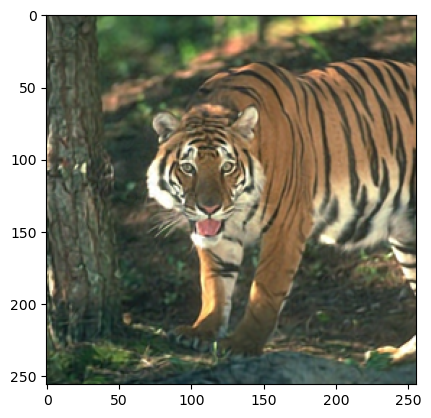

In [319]:
def eval(model_to_eval, show_img_out):
    model_output = model_to_eval(dataset.full_coords)[0]
    side_length = int(math.sqrt(model_output.shape[0]))

    mse = ((model_output - dataset.full_pixels) ** 2).mean().item()
    psnr = mse2psnr(mse)

    # Recover spatial dimension for visualization
    img_out = (
        model_output.cpu().view(side_length, side_length, -1).detach()
    )

    # Clamp image in [0, 1] for visualization
    img_out = torch.clip(img_out, 0, 1)
    if show_img_out:
        fig = plt.figure()
        plt.imshow(img_out)

    return mse, psnr, img_out

mse, psnr, img_out = eval(model, True)
print(f"mse={mse}")
print(f"psnr={psnr}")

### Weight Sparsity

In [320]:
def get_model_weight_sparsity(model):
    total_params = 0
    sparse_params = 0
    for param in model.parameters():
        total_params += torch.numel(param)
        sparse_params += torch.isclose(param, torch.zeros_like(param)).sum()
    return sparse_params / total_params

print(f"sparsity={get_model_weight_sparsity(model)}")

sparsity=0.0


### Prune Weights


In [321]:
from torch.nn.utils import prune

In [322]:
def get_module_names(model):
    module_names = []
    for param_name in dict(model.named_parameters()).keys():
        # Module name is everything in param name except for the last word
        # e.g. If param name is 'net.0.linear.weight', then module name is 'net.0.linear'
        name = '.'.join(param_name.split('.')[:-1])
        module_names.append(name)
    return module_names

def get_prunable_params(model):
    module_param_pairs = []
    module_names = get_module_names(model)
    for module_name in module_names:
        module = dict(model.named_modules())[module_name]
        module_param_pairs.append((module, "weight"))
        module_param_pairs.append((module, "bias"))
    
    return module_param_pairs

prunable_params = get_prunable_params(model)

In [323]:
def apply_pruning(prunable_params, finalize_pruning):
    for module, prunable_param_name in prunable_params:
        prune.l1_unstructured(module, prunable_param_name, amount=0.004)
        if finalize_pruning:
            prune.remove(module, prunable_param_name)

apply_pruning(prunable_params, True)
print(f"sparsity (after pruning)={get_model_weight_sparsity(model)}")

sparsity (after pruning)=0.00399668188765645


mse=0.0005312614957801998
psnr=32.74691659294781


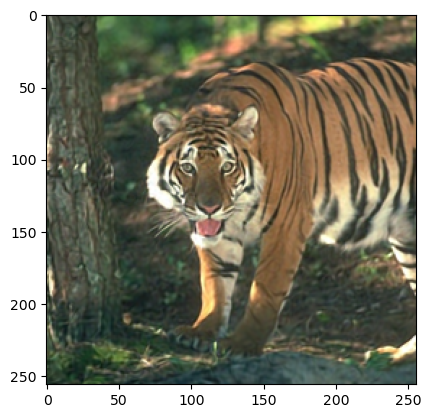

In [324]:
mse, psnr, img_out = eval(model, True)
print(f"mse={mse}")
print(f"psnr={psnr}")

Conclusion: A sparse SIREN can still reconstruct original image very well, but we cannot get such model by training with L1 penalty!